In [1]:
import pickle
import numpy as np
import pandas as pd

from scipy import optimize

import matplotlib.pyplot as plt

# Wrapper functions to work with the interpolator files

**these are the same functions that can be imported from "apc_helper_functions.py"**

In [2]:
path_to_interpolator_files = "20_APC_interpolator_files/"

prop = "7x7E"    #for testing only

In [3]:
%%time 

def get_thrust_from_RPM_speed(prop,V_ms,RPM,verbose=False):

    # speed in m/s

    filename = path_to_interpolator_files + prop + "_thrust_interpolator.pkl"
    interpolator = pickle.load(open(filename,"rb"))


    thrust_N = interpolator(V_ms,RPM)

    if ((thrust_N == -99) & (verbose == True)):
        print("parameters are out of the props envelopte")

    return float(thrust_N)


def get_power_from_RPM_speed(prop,V_ms,RPM,verbose=False):

    # speed in m/s

    filename = path_to_interpolator_files + prop + "_power_interpolator.pkl"
    interpolator = pickle.load(open(filename,"rb"))


    power_W = interpolator(V_ms,RPM)

    if (power_W == -99) & (verbose ==True):
        print("parameters are out of the props envelopte")

    return float(power_W)


#get_thrust_from_RPM_speed(prop,18,10000)
get_power_from_RPM_speed(prop,18,10000,verbose=False)

CPU times: user 156 ms, sys: 574 μs, total: 157 ms
Wall time: 83.3 ms


104.37834756661546

In [5]:
%%time

def get_power_from_thrust_speed(prop,T_req,V_ms):

    def fun(RPM,interp,thrust_request,V_ms):
        thrust_N = interp(V_ms,RPM)
    
        return thrust_N - thrust_request
    
    
    filename = path_to_interpolator_files + prop + "_thrust_interpolator.pkl"
    interp = pickle.load(open(filename,"rb"))

    RPMs = [x[1] for x in interp.points]
    
    min_RPM = min(RPMs)
    max_RPM = max(RPMs)

    max_thrust = interp(V_ms,max_RPM)

    if T_req > max_thrust:
        print("Thrust Request exceeds propeller limits!")
        return # get_power_from_RPM_speed(prop,V_ms,max_RPM,verbose=True)

    res = optimize.root_scalar(fun,args=(interp,T_req,V_ms),bracket=(min_RPM,max_RPM),rtol=.001)

    RPM = int(res.root)

    power_W = get_power_from_RPM_speed(prop,V_ms,RPM,verbose=True)
    
    return power_W


get_power_from_thrust_speed("7x7E",20,30)

CPU times: user 211 ms, sys: 4.04 ms, total: 215 ms
Wall time: 113 ms


963.5567751225727

# Wrapper Functions to query database

In [89]:
path = "20_APC_interpolator_files/"

In [90]:
filename = "APC-Prop-DB.pkl"
df = pd.read_pickle(filename)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283830 entries, 0 to 29
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PROP           283830 non-null  object 
 1   DIAM           283830 non-null  float64
 2   PITCH          283830 non-null  float64
 3   EXTENSION      283830 non-null  object 
 4   RPM            283830 non-null  int64  
 5   V_ms           283830 non-null  float64
 6   V_mph          283830 non-null  float64
 7   J              283830 non-null  float64
 8   Pe             281701 non-null  float64
 9   Ct             281701 non-null  float64
 10  Cp             281701 non-null  float64
 11  PWR_Hp         281701 non-null  float64
 12  Torque_In_Lbf  281701 non-null  float64
 13  Thrust_Lbf     281701 non-null  float64
 14  PWR_W          281701 non-null  float64
 15  Torque_Nm      281701 non-null  float64
 16  Thrust_N       281701 non-null  float64
 17  THR/PWR_g_W    281701 non-null  float6

In [96]:
T_req = 20  # N
V_ms = 30   # m/s
diam_max = 10

fdf = df[(df.Thrust_N>T_req)&(df.V_ms>V_ms)&(df.DIAM<=diam_max)].copy()
fdf.sort_values(by=["THR/PWR_g_W"],ascending=False,inplace=True)
fdf.head(10)

,PROP,DIAM,PITCH,EXTENSION,RPM,V_ms,V_mph,J,Pe,Ct,...,PWR_Hp,Torque_In_Lbf,Thrust_Lbf,PWR_W,Torque_Nm,Thrust_N,THR/PWR_g_W,Mach,Reyn,FOM
17,10x7,10.0,7.0,,14000,30.559654,68.36,0.5156,0.7237,0.0730,...,1.149,5.171,4.560,856.490,0.584,20.284,2.415,0.56,198515.0,0.3026
18,10x7SF,10.0,7.0,SF,13000,30.130496,67.40,0.5475,0.7110,0.0913,...,1.243,6.025,4.916,926.646,0.681,21.865,2.406,0.52,235815.0,0.3130
15,10x10E,10.0,10.0,E,12000,30.809997,68.92,0.6065,0.7255,0.1057,...,1.229,6.455,4.851,916.447,0.729,21.579,2.401,0.48,143205.0,0.3103
15,95x7N,9.5,7.0,N,16000,30.188611,67.53,0.4692,0.7055,0.0757,...,1.283,5.054,5.027,956.780,0.571,22.360,2.383,0.61,148573.0,0.3300
18,10x58EP(F2B),10.0,5.8,EP(F2B),16000,30.734000,68.75,0.4537,0.7179,0.0597,...,1.243,4.898,4.869,927.161,0.553,21.657,2.382,0.64,194180.0,0.3084
16,10x8E,10.0,8.0,E,14000,31.346445,70.12,0.5289,0.7242,0.0870,...,1.403,6.317,5.435,1046.392,0.714,24.174,2.356,0.56,166477.0,0.3222
19,10x55MR,10.0,5.5,MR,16000,30.961990,69.26,0.4571,0.7133,0.0583,...,1.231,4.848,4.753,917.694,0.548,21.140,2.349,0.64,212233.0,0.3005
18,10x6E,10.0,6.0,E,16000,31.417971,70.28,0.4639,0.7235,0.0598,...,1.264,4.978,4.879,942.344,0.562,21.700,2.348,0.64,189365.0,0.3043
16,9x75SF,9.0,7.5,SF,14000,30.126026,67.39,0.5648,0.6934,0.1228,...,1.304,5.873,5.034,972.763,0.664,22.391,2.347,0.51,206200.0,0.3433
18,10x5,10.0,5.0,,17000,30.166259,67.48,0.4192,0.6934,0.0528,...,1.261,4.676,4.860,940.441,0.528,21.617,2.344,0.68,239160.0,0.3032


### Plot single Prop

In [128]:
prop = "7x7E" 

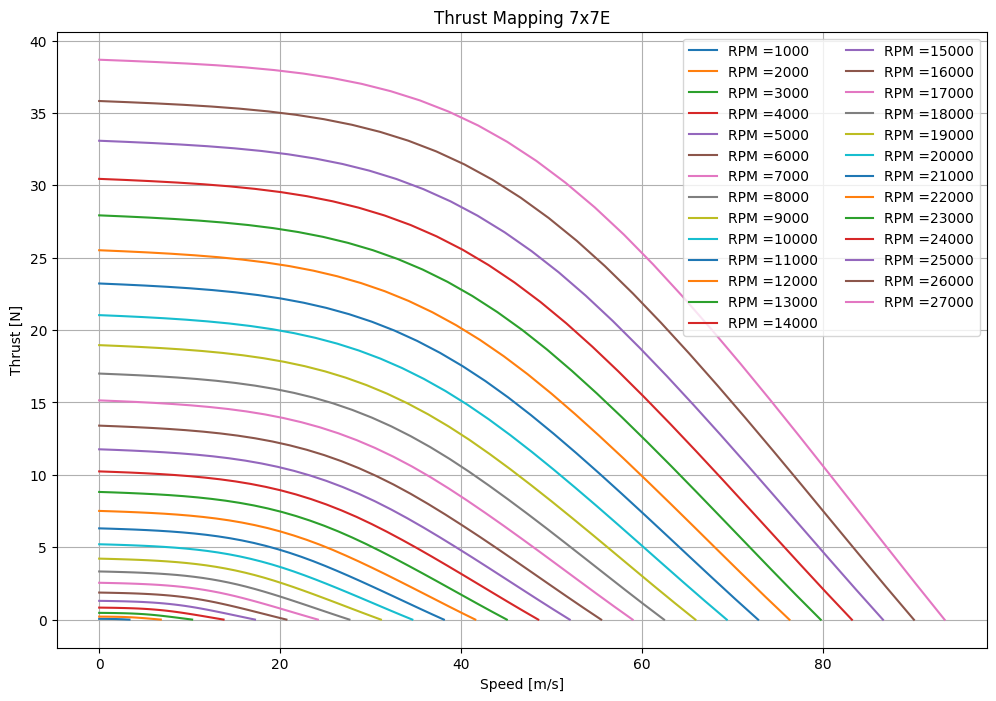

In [225]:
def plot_prop(prop):

    filename = "APC-Prop-DB.pkl"
    
    df = pd.read_pickle(filename)
    prop_df = df[df.PROP==prop] 
    
    fig, ax = plt.subplots(1,figsize=[12,8])
    
    for RPM in prop_df.RPM.unique():
            
        pdf = prop_df[prop_df.RPM==RPM]
        ax.plot(pdf.V_ms,pdf.Thrust_N,label = "RPM ="+str(RPM))
        
        
    #ax.plot(speeds,thrusts,color="grey",marker="x",lw=0.5,label=" Thrust prediction for 22500 RPM")
    
    
    ax.legend(loc="best",ncol=2)
    ax.grid(True)
    
    #ax.set_ylim(-1,40)
    
    ax.set_xlabel("Speed [m/s]")
    ax.set_ylabel("Thrust [N]")
    
    plt.title("Thrust Mapping "+prop)

plot_prop(prop)

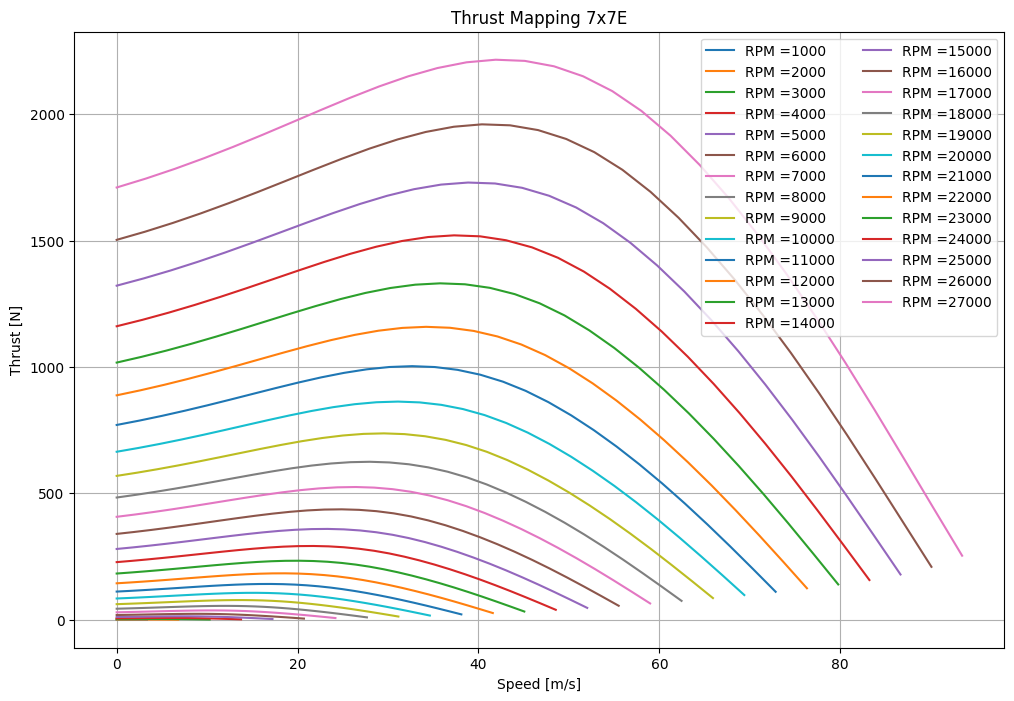

In [224]:
def plot_prop_power(prop):

    filename = "APC-Prop-DB.pkl"
    
    df = pd.read_pickle(filename)
    prop_df = df[df.PROP==prop] 
    
    fig, ax = plt.subplots(1,figsize=[12,8])
    
    for RPM in prop_df.RPM.unique():
            
        pdf = prop_df[prop_df.RPM==RPM]
        ax.plot(pdf.V_ms,pdf.PWR_W,label = "RPM ="+str(RPM))
        
        
    #ax.plot(speeds,thrusts,color="grey",marker="x",lw=0.5,label=" Thrust prediction for 22500 RPM")
    
    
    ax.legend(loc="best",ncol=2)
    ax.grid(True)
    
    #ax.set_ylim(-1,40)
    
    ax.set_xlabel("Speed [m/s]")
    ax.set_ylabel("Thrust [N]")
    
    plt.title("Thrust Mapping "+prop)

plot_prop_power(prop)

### Plot max. Prop Performance Chart

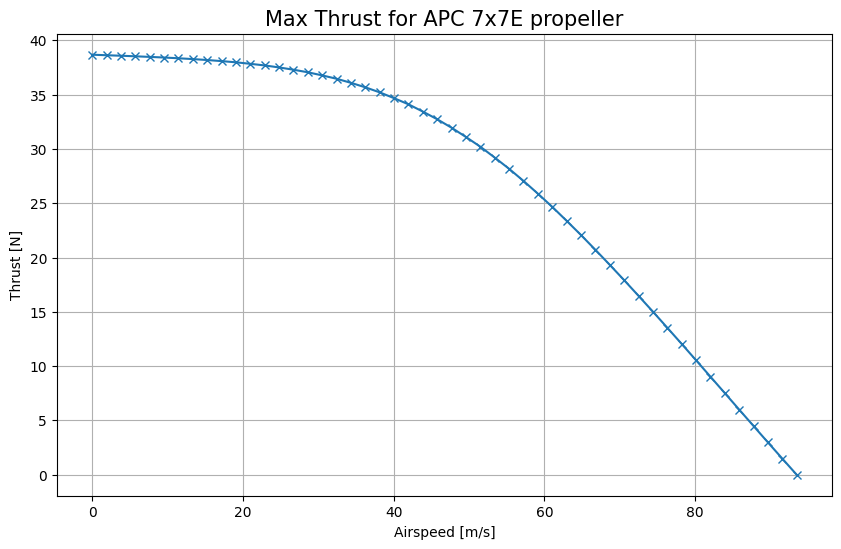

In [222]:
prop = "7x7E" 

def plot_prop_max_thrust(prop):
    filename = path_to_interpolator_files + prop + "_thrust_interpolator.pkl"
    interp = pickle.load(open(filename,"rb"))
    
    speeds = [x[0] for x in interp.points]
    RPMs = [x[1] for x in interp.points]
    
    min_speed = min(speeds)
    max_speed = max(speeds)
    min_RPM = min(RPMs)
    max_RPM = max(RPMs)
    
    thrusts = []
    
    pspeeds = np.linspace(min_speed,max_speed,50)
    
    for speed in pspeeds:  
        thrusts.append(interp(speed,max_RPM))
    
                    
    fig, ax = plt.subplots(1,figsize=[10,6])
    
    ax.plot(pspeeds,thrusts,marker="x")    
    
    ax.grid("both")
    
    ax.set_title("Max Thrust for APC "+prop+" propeller",size=15)
    ax.set_xlabel("Airspeed [m/s]")
    ax.set_ylabel("Thrust [N]")


plot_prop_max_thrust(prop)